In [1]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, RANSACRegressor

from scipy import stats

import joblib

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

from netCDF4 import Dataset, num2date, date2num
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [2]:
fname = '../generalStatistics/goodData_ASwithTAO_with2hrStatsConv.nc'
ds = xr.open_dataset(fname)
ds['mean_WVEL'] = np.sqrt(ds['mean_U10N_x'] **2 + ds['mean_U10N_y']**2)

In [3]:
data = ds.to_dataframe()
df = data.copy()

In [4]:
ds

<xarray.Dataset>
Dimensions:                                                     (count: 148300)
Coordinates:
  * count                                                       (count) int64 ...
Data variables: (12/88)
    Wind Direction (TAO)                                        (count) float32 ...
    WDIR_QC                                                     (count) float32 ...
    WDIR_DM                                                     (count) |S1 b...
    Wind Speed (TAO)                                            (count) float32 ...
    WSPD_QC                                                     (count) float32 ...
    WSPD_DM                                                     (count) |S1 b...
    ...                                                          ...
    Direction Difference (QuikSCAT - TAO 2hr mean)              (count) float64 ...
    cos(Direction Difference (QuikSCAT - TAO 2hr mean))         (count) float64 ...
    sin(Direction Difference (QuikSCAT - TAO 2hr mean))         (count) float64 ...
    Zonal Wind Speed Difference (QuikSCAT - TAO 2hr mean)       (count) float64 ...
    Meridional Wind Speed Difference (QuikSCAT - TAO 2hr mean)  (count) float64 ...
    mean_WVEL                                                   (count) float64 ...

In [5]:
selectX = ['Speed Difference (ASCAT - TAO)',
          'cos(Direction Difference (ASCAT - TAO))',
          'sin(Direction Difference (ASCAT - TAO))']

X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

In [6]:
# load trained model 
classifier = joblib.load("../../classification_machineLearning/randomForest/random_forest_rainDetection.joblib")

# Features used for classification
features = ['mean_WSPD', 'mean_SST', 'mean_AIRT', 'mean_SST - AIRT', 'mean_RELH', 'std_WSPD', 'std_cosWDIR', 'std_sinWDIR', 'std_SST', 'std_AIRT', 'std_SST - AIRT', 'std_RELH']
X = df[features]

#predict rain flags
y_pred = classifier.predict(X)
df['predicted_rain_flag'] = y_pred

In [7]:
def getSlopeInterceptOffsetSpeedRatioDirectionDiff(SUBDF, lat, lon):
    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <1:
        return None
    
    Ux_AS = np.array(subDF['Zonal Wind Speed (ASCAT)'])
    Uy_AS = np.array(subDF['Meridional Wind Speed (ASCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    AS = Ux_AS + 1j * Uy_AS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = AS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio
    subDF['speed_diff'] = subDF['Wind Speed (ASCAT)'] - subDF['Neutral Wind Speed at 10m (TAO)']

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]

    subDF2 = subDF.loc[subDF['label'] == -1]
    subDF = subDF.loc[subDF['label'] == 0]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))

    dep_indx =[]
    startDates = []
    endDates = []
    
    speedRatio_slopes = []
    speedRatio_intercepts = []
    speedRatio_offsets = []
    speedRatio_r_value = []
    speedRatio_p_value = []
    speedRatio_std_err = []

    speedDiff_slopes = []
    speedDiff_intercepts = []
    speedDiff_offsets = []
    speedDiff_r_value = []
    speedDiff_p_value = []
    speedDiff_std_err = []

    direcDiff_slopes = []
    direcDiff_intercepts = []
    direcDiff_offsets = []
    direcDiff_r_value = []
    direcDiff_p_value = []
    direcDiff_std_err = []
        
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        if len(ssubDF) <5:
            continue

        startDates.append(pd.to_datetime(np.min(ssubDF['AS_TIME'])))
        endDates.append(pd.to_datetime(np.max(ssubDF['AS_TIME'])))

        ### Rergression for speed ratio
        x = ( (np.array(ssubDF['AS_TIME']) - np.datetime64(np.min(ssubDF['AS_TIME'])))/np.timedelta64(1,'D')).reshape(-1,1)
        x[x<1] = 0
        #print('np.min(x), np.max(x)', np.min(x), np.max(x))
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        #print('speed ratio np.min(y), np.max(y)', np.min(y), np.max(y))

        dep_indx.append(dep)
            
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        ## axes[0].plot(ssubDF['AS_TIME'], Y, color='k') 

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        speedRatio_slopes.append(slope)
        speedRatio_intercepts.append(intercept)
        speedRatio_offsets.append(np.mean(Y))
        speedRatio_r_value.append(r_value)
        speedRatio_p_value.append(p_value)
        speedRatio_std_err.append(std_err)


        ### Regression for speed difference
        y = np.array(ssubDF['speed_diff']).reshape(-1,1)

        #print('speed diff np.min(y), np.max(y)', np.min(y), np.max(y))
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        #axes[1].plot(ssubDF['AS_TIME'], Y, color='k')

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        speedDiff_slopes.append(slope)
        speedDiff_intercepts.append(intercept)
        speedDiff_offsets.append(np.mean(Y))
        speedDiff_r_value.append(r_value)
        speedDiff_p_value.append(p_value)
        speedDiff_std_err.append(std_err)


        ### Regression for direction difference
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)

        #print('direction diff np.min(y), np.max(y)', np.min(y), np.max(y))
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        #axes[1].plot(ssubDF['AS_TIME'], Y, color='k')

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        direcDiff_slopes.append(slope)
        direcDiff_intercepts.append(intercept)
        direcDiff_offsets.append(np.mean(Y))
        direcDiff_r_value.append(r_value)
        direcDiff_p_value.append(p_value)
        direcDiff_std_err.append(std_err)

    latVals = [lat for i in dep_indx]
    lonVals = [(lon+360)%360 for i in dep_indx]

    infoDict = {'LATITUDE': latVals,
                'LONGITUDE': lonVals,
                'Deployments': dep_indx,
                'Start Dates': startDates,
                'End Dates': endDates,
                'speedRatio_slopes': speedRatio_slopes,
                'speedRatio_intercepts': speedRatio_intercepts,
                'speedRatio_offsets': speedRatio_offsets,
                'speedRatio_r_value': speedRatio_r_value,
                'speedRatio_p_value': speedRatio_p_value,
                'speedRatio_std_err': speedRatio_std_err,
                'speedDiff_slopes': speedDiff_slopes,
                'speedDiff_intercepts': speedDiff_intercepts,
                'speedDiff_offsets': speedDiff_offsets,
                'speedDiff_r_value': speedDiff_r_value,
                'speedDiff_p_value': speedDiff_p_value,
                'speedDiff_std_err': speedDiff_std_err,
                'direcDiff_slopes': direcDiff_slopes,
                'direcDiff_intercepts': direcDiff_intercepts,
                'direcDiff_offsets': direcDiff_offsets,
                'direcDiff_r_value': direcDiff_r_value,
                'direcDiff_p_value': direcDiff_p_value,
                'direcDiff_std_err': direcDiff_std_err}

    outDF = pd.DataFrame(infoDict, columns = ['LATITUDE',
                                            'LONGITUDE',
                                            'Deployments',
                                            'Start Dates',
                                            'End Dates',
                                            'speedRatio_slopes',
                                            'speedRatio_intercepts',
                                            'speedRatio_offsets',
                                            'speedRatio_r_value',
                                            'speedRatio_p_value',
                                            'speedRatio_std_err',
                                            'speedDiff_slopes',
                                            'speedDiff_intercepts',
                                            'speedDiff_offsets',
                                            'speedDiff_r_value',
                                            'speedDiff_p_value',
                                            'speedDiff_std_Diff',
                                            'direcDiff_slopes',
                                            'direcDiff_intercepts',
                                            'direcDiff_offsets',
                                            'direcDiff_r_value',
                                            'direcDiff_p_value',
                                            'direcDiff_std_err'])
    return outDF
        

In [8]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

In [9]:
allDataDF = []
for i in range(ntasks):
    lat = taskList[i][0]
    lon = taskList[i][1]
    infoDF = getSlopeInterceptOffsetSpeedRatioDirectionDiff(df, lat, lon)
    if infoDF is not None:
        allDataDF.append(infoDF)

/tmp/ipykernel_57888/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_57888/3625347035.py:17: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_57888/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_57888/3625347035.py:17: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_57888/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_57888/3625347035.py:17: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_57888/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_57888/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_57888/3625347035.py:17: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_57888/3625347035.py:17: RuntimeWarning: div

In [10]:
len(allDataDF)

51

In [11]:
allDataDFconcated = pd.concat(allDataDF, axis=0, join='outer')

In [12]:
allDataDFconcated.head()

,LATITUDE,LONGITUDE,Deployments,Start Dates,End Dates,speedRatio_slopes,speedRatio_intercepts,speedRatio_offsets,speedRatio_r_value,speedRatio_p_value,...,speedDiff_offsets,speedDiff_r_value,speedDiff_p_value,speedDiff_std_Diff,direcDiff_slopes,direcDiff_intercepts,direcDiff_offsets,direcDiff_r_value,direcDiff_p_value,direcDiff_std_err
0,-8,265,0,2000-01-02 23:44:31.511134320,2000-04-28 12:08:22.081368568,0.000433,0.982235,1.006212,1.0,0.0,...,-0.013046,1.0,0.0,NaN,-0.084785,3.945621,-0.746983,-1.0,0.0,0.000000e+00
1,-8,265,1,2000-05-01 12:32:56.815176440,2000-11-02 00:41:16.205012240,-0.000387,1.039380,1.003838,-1.0,0.0,...,0.054801,-1.0,0.0,NaN,0.022312,-5.522850,-3.471491,1.0,0.0,0.000000e+00
2,-8,265,4,2001-11-05 12:48:43.830542496,2002-03-18 23:54:38.102807216,-0.000189,1.015660,1.003029,-1.0,0.0,...,0.031500,-1.0,0.0,NaN,-0.042454,3.122504,0.290687,-1.0,0.0,0.000000e+00
3,-8,265,5,2002-03-22 00:17:45.688205632,2002-10-19 12:34:07.695738704,0.000333,0.951022,0.985545,1.0,0.0,...,0.438720,-1.0,0.0,NaN,0.027324,-4.828146,-1.995696,1.0,0.0,0.000000e+00
4,-8,265,6,2002-10-22 23:58:28.859895968,2003-04-13 12:00:40.932005472,0.000348,0.957094,0.987573,1.0,0.0,...,-0.106579,1.0,0.0,NaN,0.007648,-5.333065,-4.663639,1.0,0.0,9.051888e-12


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

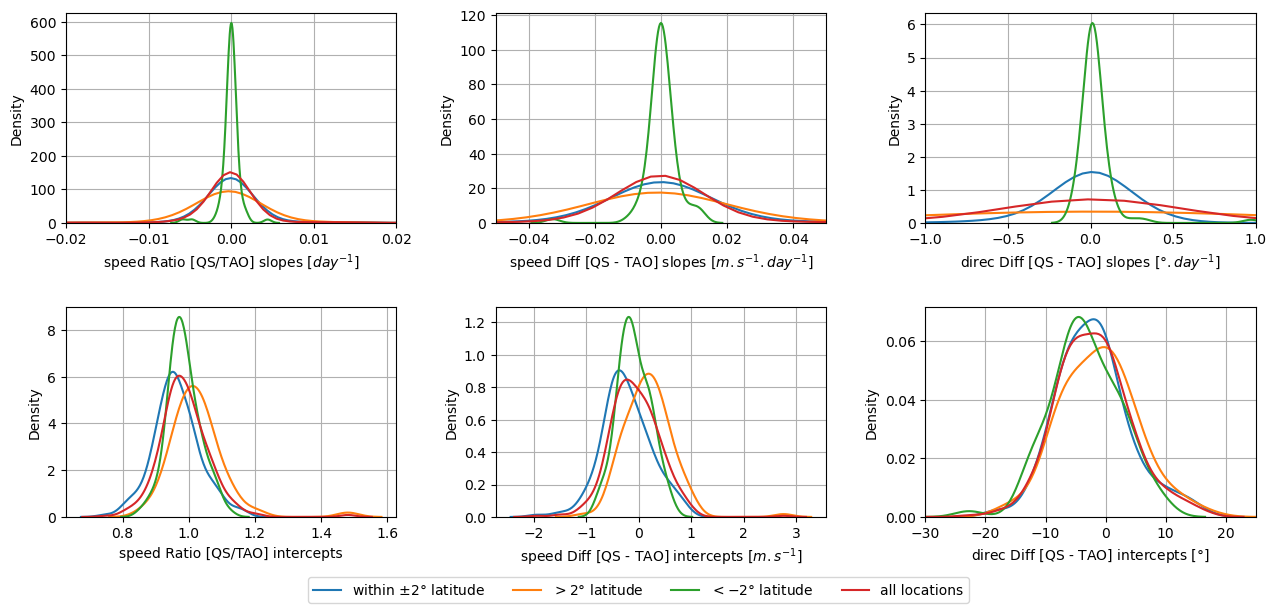

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

test = allDataDFconcated.loc[abs(allDataDFconcated['LATITUDE']) <= 2]
test1 = allDataDFconcated.loc[allDataDFconcated['LATITUDE'] > 2]
test2 = allDataDFconcated.loc[allDataDFconcated['LATITUDE'] < -2]

xlabel1 = 'speedRatio_slopes'
xlabel2 = 'speedDiff_slopes'
xlabel3 = 'direcDiff_slopes'
xlabel4 = 'speedRatio_intercepts'
xlabel5 = 'speedDiff_intercepts'
xlabel6 = 'direcDiff_intercepts'


fig_xlabel1 = 'speed Ratio [AS/TAO] slopes [$day^{-1}$]'
fig_xlabel2 = 'speed Diff [AS - TAO] slopes [$m.s^{-1}.day^{-1}$]'
fig_xlabel3 = 'direc Diff [AS - TAO] slopes [$\degree.day^{-1}$]'
fig_xlabel4 = 'speed Ratio [AS/TAO] intercepts'
fig_xlabel5 = 'speed Diff [AS - TAO] intercepts [$m.s^{-1}$]'
fig_xlabel6 = 'direc Diff [AS - TAO] intercepts [$\degree$]'

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 6), sharex=False, sharey=False)

labels = [r'within $\pm 2\degree$ latitude', r'$ > 2\degree$ latitude', r'$< -2\degree$ latitude', 'all locations']
xlabels = [xlabel1, xlabel2, xlabel3, xlabel4, xlabel5, xlabel6]
fig_xlabels = [fig_xlabel1, fig_xlabel2, fig_xlabel3, fig_xlabel4, fig_xlabel5, fig_xlabel6]
xlims = [(-0.02, 0.02), (-0.05, 0.05), (-1, 1), None, None, (-30,25)]

for i, ax in enumerate(axes.flat):
    sns.kdeplot(test, x=xlabels[i], ax=ax, label=labels[0])
    sns.kdeplot(test1, x=xlabels[i], ax=ax, label=labels[1])
    sns.kdeplot(test2, x=xlabels[i], ax=ax, label=labels[2])
    sns.kdeplot(allDataDFconcated, x=xlabels[i], ax=ax, label=labels[3])
    
    if xlims[i] is not None:
        ax.set_xlim(xlims[i])
    
    ax.set_xlabel(fig_xlabels[i])
    ax.grid()

# Create a single legend below all plots
handles, labels = axes[1, 2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize='medium')

# Adjust layout to make space for the legend
plt.subplots_adjust(left= 0.05, hspace=0.4, wspace=0.3, bottom=0.15, top=0.99)

plt.savefig('pdf_of_slopes_intercepts_from_timeSeries.pdf', dpi=100)
